In [43]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import FFT
from darts.metrics import mape,mae,rmse
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
# 1. Data preprocessing
df = pd.read_csv('../Dataset/VCB-Historical-Data_Group 9.csv')
# df = df.iloc[::-1] 
df['Date'] = pd.to_datetime(df['Date'],format='mixed')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df = df[['Date','Price']]
df

,Date,Price
0,2024-03-01,97300.0
1,2024-02-29,97300.0
2,2024-02-28,97400.0
3,2024-02-27,91100.0
4,2024-02-26,89500.0
...,...,...
1247,2019-03-07,48456.0
1248,2019-03-06,48149.0
1249,2019-03-05,48379.0
1250,2019-03-04,48226.0


In [45]:
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

In [46]:
# 2. Prepare TimeSeries data
ts = TimeSeries.from_dataframe(df,time_col='Date',value_cols='Price', freq='D')

In [47]:
# 3. Split data into training and test sets

total_length = len(ts)
train_size = int(0.7 * total_length)

train, test = ts.split_before(ts.time_index[train_size])


In [48]:
# 4. Define and fit the FFT model on train set, then make predictions on test set
fft_model = FFT(required_matches={'day'}, trend='exp')
model_fit = fft_model.fit(train)

y_pred = model_fit.predict(len(test))

In [49]:
# 5. Predict for the next 30 days

# Convert the date range to pandas datetimes
next_30_days_index = pd.date_range(start=test.time_index[0] + pd.DateOffset(days=1), periods=len(test) + 30)
x_30 = pd.to_datetime(next_30_days_index)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(len(x_30))
y_next_30_days_trimmed = y_next_30_days[len(test):]

y_pred_30 = TimeSeries.from_times_and_values(
    times= next_30_days_index[len(test):],
    values= y_next_30_days_trimmed.values(),
    fill_missing_dates=True  
)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days_trimmed.values())


Predicted closing prices for the next 30 days:
[[100949.07789212]
 [100947.78967865]
 [100948.84295419]
 [100952.66022782]
 [100959.66119134]
 [100970.26112441]
 [100984.86930974]
 [101003.88746414]
 [101027.70819123]
 [101056.71346157]
 [101091.27312553]
 [101131.74346476]
 [101178.4657872 ]
 [101231.76507116]
 [101291.94866326]
 [101359.30503508]
 [101434.10260329]
 [101516.5886174 ]
 [101606.98811946]
 [101705.50297956]
 [101812.31101062]
 [101927.56516604]
 [102051.39282294]
 [102183.89515398]
 [102325.14659006]
 [102475.19437587]
 [102634.05822025]
 [102801.73004262]
 [102978.1738165 ]
 [103163.32551102]]


In [51]:
# 6. Model evaluation
mape_value = mape(test, y_pred)
mae_value = mae(test, y_pred)
rmse_value = rmse(test, y_pred)

print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Error (MAE):", mae_value)
print("Root Mean Squared Error (RMSE):", rmse_value)


Mean Absolute Percentage Error (MAPE): 9.671772849253081
Mean Absolute Error (MAE): 8094.832356570769
Root Mean Squared Error (RMSE): 9219.194725675343


<Axes: xlabel='time'>

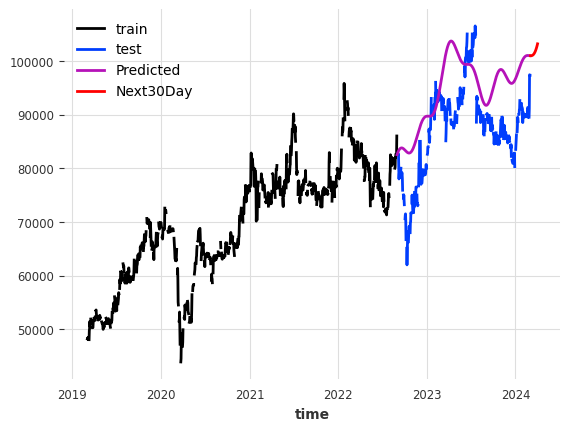

In [52]:
# 7. Plotting
train.plot(label="train")
test.plot(label="test")
y_pred.plot(label="Predicted")
y_pred_30.plot(label="Next30Day", color = 'r')
